In [393]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import get_recording_time,plot_probe, assign_DIO_times_to_trials, Trim_TTLs, select_DIO_sync_trial_trace, stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, extract_time, extract_analogIO, check_single_rec_file, extract_DIO, check_timestamp_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
import spikeinterface.full as si
from spikeinterface.preprocessing import detect_bad_channels
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import panel as pn
from tqdm.notebook import tqdm

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# TODO:
# check gaps mouse 12 20240126
# check gaps mouse 13 20231212
# check timestamps.dat == spikeinterface times

# **Ott lab process single session**
#####  Multi-Neuropixels recording using SpikeGadgets + Bpod

# Select file

In [305]:
# folder containing .rec file
path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/")


In [306]:
mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)
time = get_recording_time(path_recording_folder)
print(f"mouse {mouse_n} recorded on {day} at {time}")

mouse 12 recorded on 20231210 at 19:18:35


In [340]:
time

datetime.time(19, 18, 35)

In [338]:
raw_rec.get_total_duration()

1058.6749333333332

In [307]:
path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20231210_191835.rec


In [308]:
# Load in spikeinterface
raw_rec = read_spikegadgets(path_recording)
fs = raw_rec.get_sampling_frequency()

In [309]:
print(f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz")
print(f"Probes present: {raw_rec.get_probes()}")

Recording duration in minutes: 17.64458222222222, sampling rate: 30000.0 Hz
Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]


# Sync Bpod and Trodes streams

### Export Digital IO channels

In [312]:
%%time
#check if already available, if not extract
extract_DIO(path_recording_folder, path_recording) # TODO what is timestampoffset?

'.DIO' folder alread available: 20231210_191835.DIO
CPU times: user 1.94 ms, sys: 0 ns, total: 1.94 ms
Wall time: 2.34 ms


In [325]:
DIO_timestamps_start_trial, DIO_samples_start_trial = select_DIO_sync_trial_trace(path_recording_folder, rec_file_name)

20231210_191835.dio_Controller_Din1.dat contains data
1 DIO files with data


## load bpod mat file behavior

In [346]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , path_recording_folder, raw_rec)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_193822/12_DetectionConfidence_20231210_193822.mat


.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat
Bpod file starts within the Trodes recording


/alzheimer/Roberto/Dariya/12/bpod_session/20231210_183107/12_DetectionConfidence_20231210_183107.mat
Bpod session started at 19:19:28, duration: 16.664601666666666 min, ended at: 19:36:07
number trials: 98
Extracting DetectionConfidence params
CPU times: user 94 ms, sys: 4.46 ms, total: 98.4 ms
Wall time: 95.4 ms


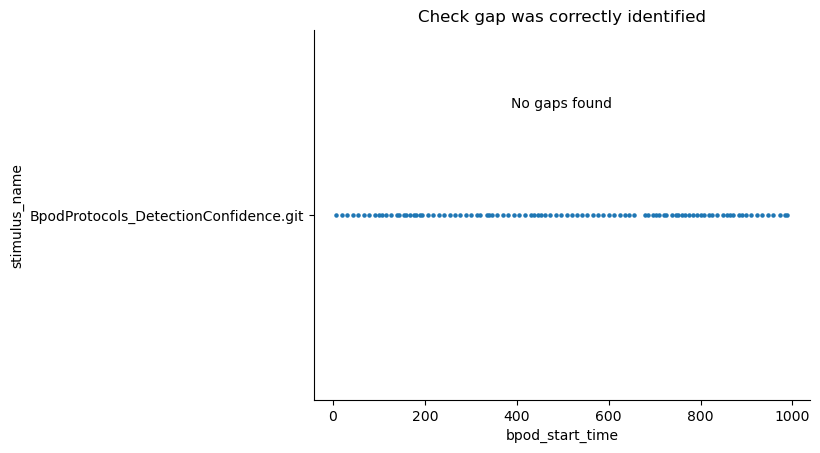

In [347]:
%%time
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_start_trial)

The most distant pulse in array1 is at index 98 with time 993.3022333333333
This pulse has a minimum distance of 11.916033744812012 to the closest pulse in array2


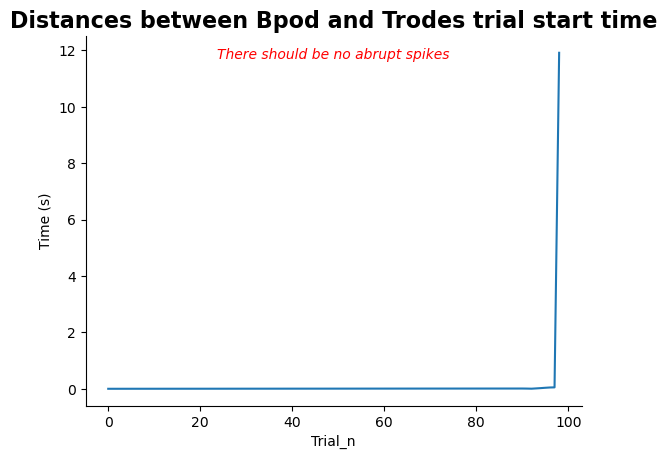

In [348]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

In [349]:
# only adapted to case where there is a extra TTL in the DIO at the end of last stimulus block!
DIO_timestamps_start_trial,  DIO_samples_start_trial = Trim_TTLs(trials, DIO_timestamps_start_trial, DIO_samples_start_trial,min_distances)

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


The most distant pulse in array1 is at index 97 with time 981.3359666666668
This pulse has a minimum distance of 0.05023333430290222 to the closest pulse in array2


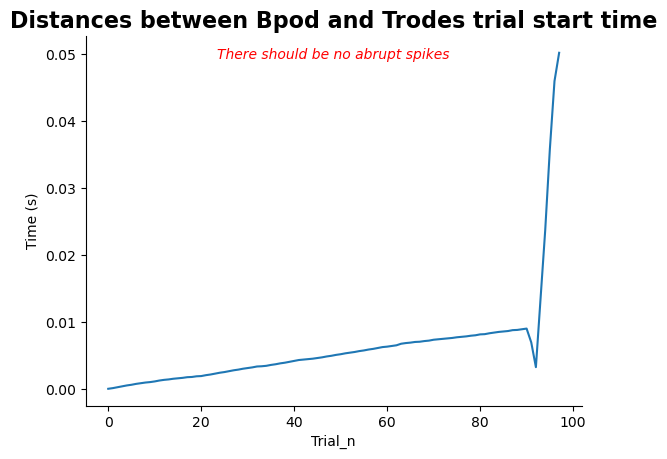

In [350]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

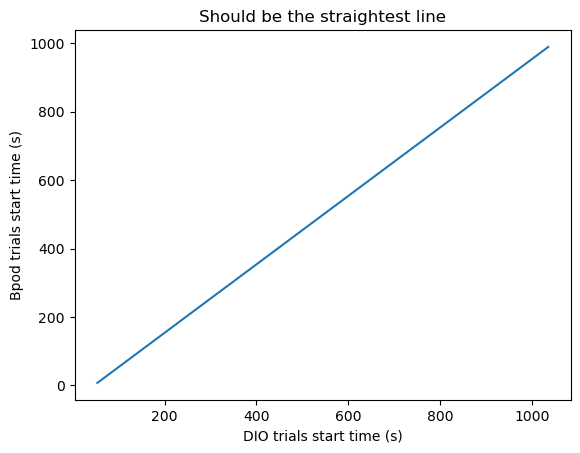

In [351]:
%%time
trials = assign_DIO_times_to_trials(trials, DIO_timestamps_start_trial, DIO_samples_start_trial)

In [352]:
%%time
# assign trodes times
times = raw_rec.get_times()
trials["start_time"] = times[trials["DIO_start_sample_zeroed"]]
trials

CPU times: user 92.1 ms, sys: 474 ms, total: 566 ms
Wall time: 568 ms


,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,AfterTrialInterval,BeforeTrialInterval,Beta,BiasVersion,BlockBias,BlockNoise,...,SignalDuration,SignalVolume,StimDuration,WaitingTime,StimulusStartTime,RewardStartTime,DIO_start_sample,DIO_start_time,DIO_start_sample_zeroed,start_time
0,7.4648,18.4899,0,BpodProtocols_DetectionConfidence.git,1,1,-0.847712,1,0.5,40,...,0.1,55.431371,0.1,NaN,NaN,NaN,1608245,53.608167,0,0.000000
1,19.4012,30.4263,0,BpodProtocols_DetectionConfidence.git,1,1,-0.997810,1,0.5,40,...,0.1,59.934287,0.1,NaN,NaN,NaN,1966340,65.544667,358095,11.936500
2,31.2975,42.3226,0,BpodProtocols_DetectionConfidence.git,1,1,-1.000000,1,0.5,40,...,0.1,60.000000,0.1,NaN,NaN,NaN,2323233,77.441100,714988,23.832933
3,43.1718,54.1969,0,BpodProtocols_DetectionConfidence.git,1,1,1.000000,1,0.5,40,...,0.1,60.000000,0.1,NaN,NaN,NaN,2679466,89.315533,1071221,35.707367
4,55.0648,66.0899,0,BpodProtocols_DetectionConfidence.git,1,1,-0.986815,1,0.5,40,...,0.1,59.604446,0.1,NaN,NaN,NaN,3036260,101.208667,1428015,47.600500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,945.8506,956.8757,0,BpodProtocols_DetectionConfidence.git,1,1,0.201691,1,0.5,40,...,0.1,36.050715,0.1,NaN,NaN,NaN,29759415,991.980500,28151170,938.372333
94,957.7820,971.1213,0,BpodProtocols_DetectionConfidence.git,1,1,-0.920038,1,0.5,40,...,0.1,57.601130,0.1,1.2405,10.8558,12.8407,30117051,1003.901700,28508806,950.293533
95,971.9916,983.0167,0,BpodProtocols_DetectionConfidence.git,1,1,-0.189392,1,0.5,40,...,0.1,35.681759,0.1,NaN,NaN,NaN,30542975,1018.099167,28934730,964.491000
96,983.9097,987.9648,0,BpodProtocols_DetectionConfidence.git,1,1,-0.378655,1,0.5,40,...,0.1,41.359642,0.1,0.6441,2.2236,3.2589,30900212,1030.007067,29291967,976.398900


# Spike sorting

## Pre-processing

### Highpass filter

In [291]:
rec_filt = si.highpass_filter(raw_rec, freq_min=300.)

### Detect bad channels

In [143]:
%%time
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = detect_bad_channels(rec_filt, dead_channel_threshold=-1)

CPU times: user 56 s, sys: 48.8 s, total: 1min 44s
Wall time: 2min 22s


In [144]:
# count bad channels
count = np.unique(channel_labels, return_counts=True)
if (count[0].shape[0] == 1) & (count[0][0]=="good"):
     print("no bad channels")
else:
    for n in range(count[0].shape[0]):
        print(f"{count[1][n]} {count[0][n]} channels")

no bad channels


### Inspect probes

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
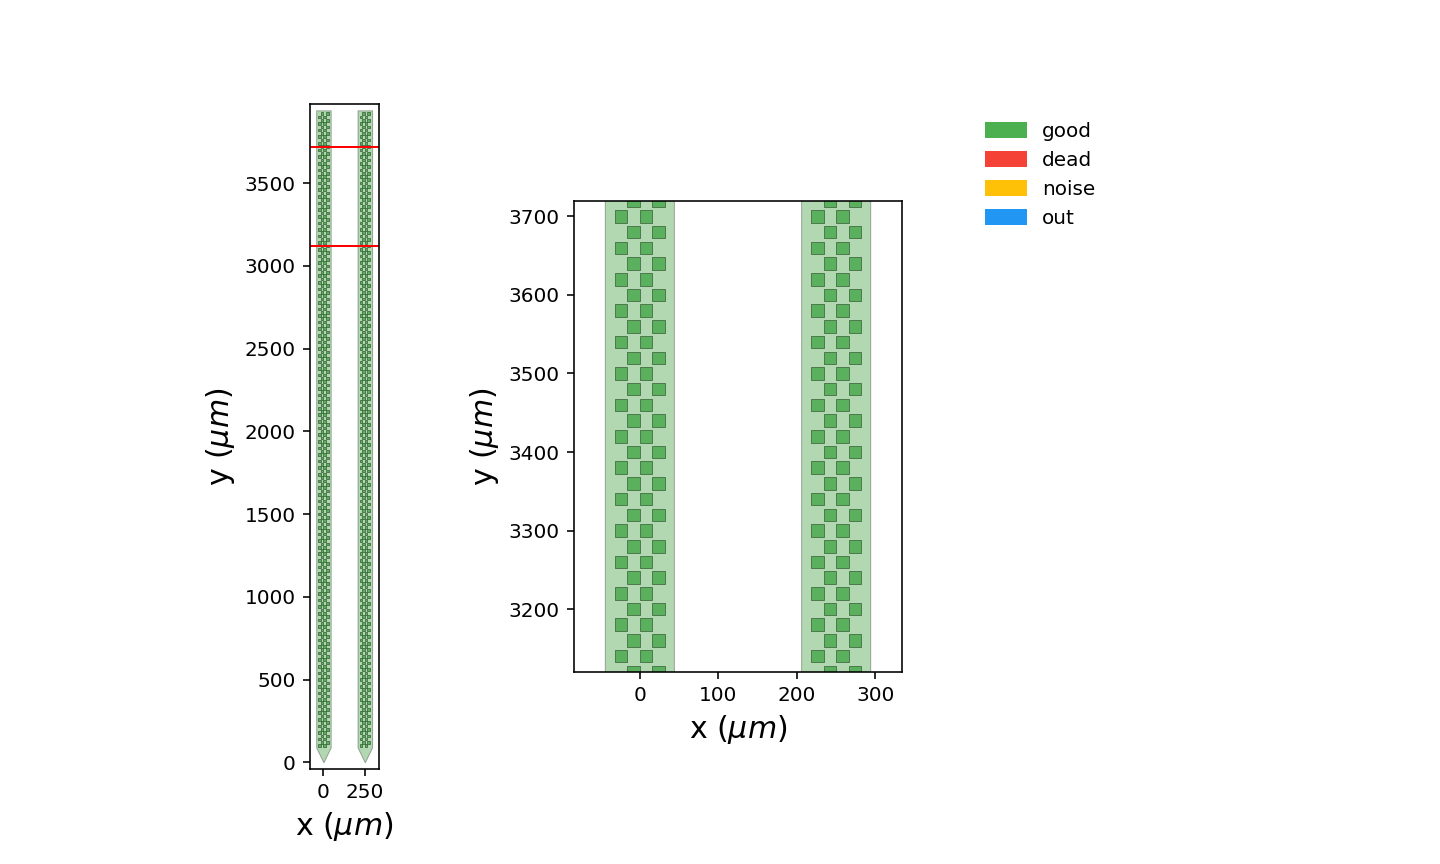

In [145]:
plot_probe(raw_rec, channel_labels)

In [ ]:
# remove bad channels
rec_filt = rec_filt.remove_channels(bad_channel_ids)
print("bad channels removed")

## Sorting

In [ ]:
from spikeinterface.qualitymetrics import compute_quality_metrics

In [292]:
%%time

check_gpu_availability()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = si.run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 277320457
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  343.99s; total  343.99s

computing drift
Re-computing universal templates from data.


 16%|██████████████████████████████▍                                                                                                                                                           | 757/4623 [39:31<3:21:49,  3.13s/it]

KeyboardInterrupt



## Post-processing

In [399]:
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer
from spikeinterface.qualitymetrics import compute_quality_metrics
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.postprocessing import compute_template_metrics

In [ ]:
%%time
for probe in tqdm(os.listdir(f"{path_recording_folder}/spike_interface_output")):
    if os.path.exists(f"{path_recording_folder}/spike_interface_output/{probe}/sorting_analyzer.zarr/"):
        analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/{probe}/sorting_analyzer.zarr/")
    else:
        sorting = si.read_sorter_folder(f"{path_recording_folder}/spike_interface_output/{probe}")
        analyzer = create_sorting_analyzer(sorting, split_preprocessed_recording[group], sparse=True, format="memory")
        job_kwargs = dict(chunk_duration='1s', progress_bar=True, n_jobs=20)
        analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
        analyzer.compute("waveforms",  ms_before=1,ms_after=2., **job_kwargs)
        analyzer.compute("templates", operators=["average", "median", "std"])
        analyzer.compute("noise_levels")
        analyzer.compute('correlograms', **job_kwargs)
        analyzer.compute('spike_amplitudes', **job_kwargs)
        compute_template_metrics(analyzer, include_multi_channel_metrics=True)
        analyzer.compute('unit_locations', **job_kwargs)
        analyzer.compute('template_similarity', **job_kwargs)
        #analyzer.compute("principal_components", **job_kwargs)
        analyzer.save_as(folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer", format="zarr")
        
        metrics = compute_quality_metrics(analyzer, metric_names=si.get_quality_metric_list())
        metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")

In [454]:
analyzer.get_extension("templates").get_data().shape

(274, 90, 384)

In [451]:
temp = np.load("/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec/spike_interface_output/probe0/sorter_output//templates.npy")

In [455]:
job_kwargs = dict(chunk_duration='10s', progress_bar=True, n_jobs=30)

In [457]:
%%time
analyzer.compute('spike_amplitudes', **job_kwargs)
analyzer.compute('correlograms')
analyzer.compute('unit_locations', **job_kwargs)
analyzer.compute('template_similarity', **job_kwargs)

spike_amplitudes:   0%|          | 0/925 [00:00<?, ?it/s]


KeyboardInterrupt

Process ForkProcess-430:
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/ipykernel/iostream.py", line 692, in write
Process ForkProcess-409:
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/ipykernel/iostream.py", line 269, in schedule
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/ipykernel/iostream.py", line 649, in _flush
    self.session.send(
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/jupyter_client/session.py", line 863, in send
Exception in thread Thread-28:
Traceback (most recent call last):
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/alzheimer/Roberto/Software/mamb

In [ ]:
analyzer.get_extension("waveforms")

In [444]:
from spikeinterface.widgets import plot_sorting_summary

In [446]:
plot_sorting_summary(analyzer, curation=True, backend='sortingview')

Exception: The correlograms waveform extension is required for this widget. Run the `sorting_analyzer.compute('correlograms', ...)` to compute it.
The spike_amplitudes waveform extension is required for this widget. Run the `sorting_analyzer.compute('spike_amplitudes', ...)` to compute it.
The unit_locations waveform extension is required for this widget. Run the `sorting_analyzer.compute('unit_locations', ...)` to compute it.
The template_similarity waveform extension is required for this widget. Run the `sorting_analyzer.compute('template_similarity', ...)` to compute it.


In [ ]:
%%time
from tqdm.notebook import tqdm
spike_times = {}
for unit_id in tqdm(sorting.unit_ids):
    spike_times[unit_id] = times[sorting.get_unit_spike_train(unit_id=0)]

In [809]:
gaps = check_timestamp_gaps(raw_rec)

No gaps detected.


# Trash

### Export Analog IO channels

In [160]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 553 µs, sys: 109 µs, total: 662 µs
Wall time: 770 µs


### Export timestamps

In [161]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


## Load Trodes timestamps

In [174]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [280]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

NameError: name 'path_analogIO_folder' is not defined

In [178]:
analog_dict["data"].shape

(277320457,)

In [179]:
raw_rec.get_total_samples()

277320457

In [186]:
times = raw_rec.get_times()

In [188]:
times[analog_dict["data"]["time"]]

IndexError: index 277320457 is out of bounds for axis 0 with size 277320457

In [187]:
analog_dict["data"]["time"]

array([  1279032,   1279033,   1279034, ..., 278599486, 278599487,
       278599488], dtype=uint32)

In [184]:
analog_dict["first_timestamp"]

'1279032'